Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


Load Data (Preview data)

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Feature Engineering

In [3]:
# Date feature
train_df["date"] = pd.to_datetime(train_df["date"])
train_df["month"] = train_df["date"].dt.month
train_df["dayofweek"] = train_df["date"].dt.weekday

test_df["date"] = pd.to_datetime(test_df["date"])
test_df["month"] = test_df["date"].dt.month
test_df["dayofweek"] = test_df["date"].dt.weekday

#Cluster Encoding
train_df["cluster_code"] = train_df["cluster_id"].astype("category").cat.codes
test_df["cluster_code"] = test_df["cluster_id"].astype("category").cat.codes

#Temperature Range
train_df["temp_range"] = train_df["temperature_2m_max"] - train_df["temperature_2m_min"]
test_df["temp_range"] = test_df["temperature_2m_max"] - test_df["temperature_2m_min"]


Select Feature and target

In [4]:
features = [
    "temperature_2m_max",
    "temperature_2m_min",
    "apparent_temperature_max",
    "apparent_temperature_min",
    "sunshine_duration",
    "daylight_duration",
    "wind_speed_10m_max",
    "wind_gusts_10m_max",
    "wind_direction_10m_dominant",
    "shortwave_radiation_sum",
    "et0_fao_evapotranspiration",
    "month",
    "dayofweek",
    "cluster_code",
    "temp_range"
]

X = train_df[features]
y = train_df["electricity_consumption"]

X_test_final = test_df[features]

Split Training & Validation

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Baseline Random Forest

In [6]:
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_valid)
rf_rmse = np.sqrt(mean_squared_error(y_valid, rf_preds))
rf_mae = mean_absolute_error(y_valid, rf_preds)

print("Random Forest RMSE:", rf_rmse)
print("Random Forest MAE:", rf_mae)

Training Random Forest...
Random Forest RMSE: 34.19657491676071
Random Forest MAE: 23.137433680496162


XGboost + Cross Validation

In [7]:
print("\nTraining XGBoost with Cross-Validation...")
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = cross_val_score(
    xgb_model, X, y, 
    scoring='neg_mean_squared_error', 
    cv=kfold
)
print("XGBoost CV RMSE:", np.sqrt(-xgb_scores).mean())

print("XGBoost Cross-Validation RMSE scores:", -xgb_scores)
print("XGBoost Mean CV RMSE:", -xgb_scores.mean())

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_valid)
xgb_rmse = np.sqrt(mean_squared_error(y_valid, xgb_preds))
xgb_mae = mean_absolute_error(y_valid, xgb_preds)

print("XGBoost Validation RMSE:", xgb_rmse)
print("XGBoost Validation MAE:", xgb_mae)


Training XGBoost with Cross-Validation...
XGBoost CV RMSE: 31.10733476684692
XGBoost Cross-Validation RMSE scores: [ 986.91610741  871.8951104   993.15514243  974.51341003 1015.18840843]
XGBoost Mean CV RMSE: 968.3336357413646
XGBoost Validation RMSE: 31.549023188503917
XGBoost Validation MAE: 21.48920765768268


LightGBM + Hyperparameter Tuning

In [8]:
print("\nTuning LightGBM Hyperparameters...")
lgb_base = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70]
}

grid_search = GridSearchCV(
    estimator=lgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best LightGBM Params:", grid_search.best_params_)
print("Best LightGBM RMSE:", -grid_search.best_score_)

# Train best model
lgb_best = grid_search.best_estimator_
lgb_best.fit(X_train, y_train)

lgb_preds = lgb_best.predict(X_valid)
lgb_rmse = np.sqrt(mean_squared_error(y_valid, lgb_preds))
lgb_mae = mean_absolute_error(y_valid, lgb_preds)

print("LightGBM Validation RMSE:", lgb_rmse)
print("LightGBM Validation MAE:", lgb_mae)


Tuning LightGBM Hyperparameters...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 6233, number of used features: 15
[LightGBM] [Info] Start training from score 642.259294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 6233, number of used features: 15
[LightGBM] [Info] Start training from score 637.270486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Num

Visualisasi Prediksi Error

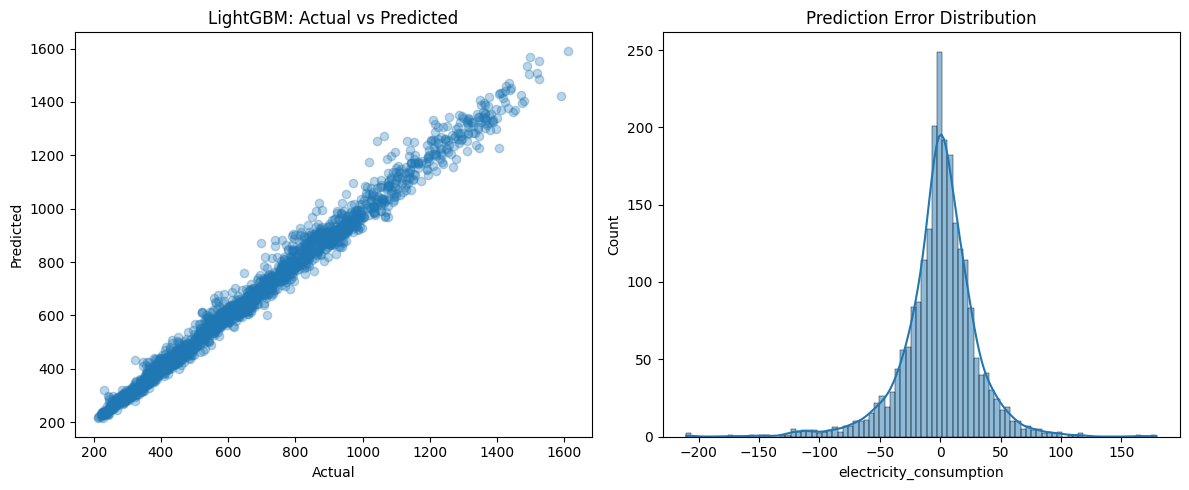

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_valid, lgb_preds, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("LightGBM: Actual vs Predicted")

plt.subplot(1,2,2)
errors = y_valid - lgb_preds
sns.histplot(errors, kde=True)
plt.title("Prediction Error Distribution")

plt.tight_layout()
plt.show()

Prediksi hasil test set dengan model terbaik

In [10]:
final_preds = lgb_best.predict(X_test_final)

In [11]:

# =========================================
# LightGBM Extended Grid Search without early stopping
# =========================================
print("\nTuning LightGBM Hyperparameters with Extended Grid...")
lgb_base = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.02, 0.05],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=lgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best LightGBM Params:", best_params)
print("Best LightGBM RMSE:", np.sqrt(-grid_search.best_score_))

# =========================================
# Create new model with best params and early stopping
# =========================================
lgb_best = lgb.LGBMRegressor(
    **best_params,
    random_state=42
)
lgb_best.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False
)

# Validation predictions
lgb_preds = lgb_best.predict(X_valid)
lgb_rmse = np.sqrt(mean_squared_error(y_valid, lgb_preds))
lgb_mae = mean_absolute_error(y_valid, lgb_preds)

print("LightGBM Validation RMSE:", lgb_rmse)
print("LightGBM Validation MAE:", lgb_mae)

# =========================================
# Cross-Validation Full Dataset
# =========================================
print("\nRunning 5-Fold Cross-Validation on Full Dataset...")
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    lgb_best, X, y,
    scoring='neg_mean_squared_error',
    cv=kfold
)
print("LightGBM 5-Fold CV RMSE mean:", np.sqrt(-cv_scores.mean()))
print("LightGBM 5-Fold CV RMSE per fold:", np.sqrt(-cv_scores))

# =========================================
# Final Training on All Data
# =========================================
print("\nRetraining LightGBM on Full Data...")
lgb_best.fit(X, y, eval_metric='rmse')

# Predict Test Set
final_preds = lgb_best.predict(X_test_final)

# Prepare Submission
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "electricity_consumption": final_preds
})
submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv created successfully.")



Tuning LightGBM Hyperparameters with Extended Grid...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 6233, number of used features: 15
[LightGBM] [Info] Start training from score 642.259294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 6233, number of used features: 15
[LightGBM] [Info] Start training from score 637.270486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970


TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'